In [1]:
import sys
import numpy as np
import time
import sys, os

import random
import gc
import scipy.ndimage as ndimage
from skimage.transform import resize
import matplotlib.pyplot as plt

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn

plt.rcParams['image.cmap'] = 'coolwarm'


In [2]:
def ks93(g1, g2):
    """Direct inversion of weak-lensing shear to convergence.
    This function is an implementation of the Kaiser & Squires (1993) mass
    mapping algorithm. Due to the mass sheet degeneracy, the convergence is
    recovered only up to an overall additive constant. It is chosen here to
    produce output maps of mean zero. The inversion is performed in Fourier
    space for speed.
    Parameters
    ----------
    g1, g2 : array_like
        2D input arrays corresponding to the first and second (i.e., real and
        imaginary) components of shear, binned spatially to a regular grid.
    Returns
    -------
    kE, kB : tuple of numpy arrays
        E-mode and B-mode maps of convergence.
    Raises
    ------
    AssertionError
        For input arrays of different sizes.
    See Also
    --------
    bin2d
        For binning a galaxy shear catalog.
    Examples
    --------
    >>> # (g1, g2) should in practice be measurements from a real galaxy survey
    >>> g1, g2 = 0.1 * np.random.randn(2, 32, 32) + 0.1 * np.ones((2, 32, 32))
    >>> kE, kB = ks93(g1, g2)
    >>> kE.shape
    (32, 32)
    >>> kE.mean()
    1.0842021724855044e-18
    """
    # Check consistency of input maps
    assert g1.shape == g2.shape

    # Compute Fourier space grids
    (nx, ny) = g1.shape
    k1, k2 = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx))

    # Compute Fourier transforms of g1 and g2
    g1hat = np.fft.fft2(g1)
    g2hat = np.fft.fft2(g2)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[0, 0] = 1  # avoid division by 0
    kEhat = (p1 * g1hat + p2 * g2hat) / k2
    kBhat = -(p2 * g1hat - p1 * g2hat) / k2


    # Transform back to pixel space
    kE = np.fft.ifft2(kEhat).real
    kB = np.fft.ifft2(kBhat).real

    return kE, kB

def ks93inv(kE, kB):
    """Direct inversion of weak-lensing convergence to shear.
    This function provides the inverse of the Kaiser & Squires (1993) mass
    mapping algorithm, namely the shear is recovered from input E-mode and
    B-mode convergence maps.
    Parameters
    ----------
    kE, kB : array_like
        2D input arrays corresponding to the E-mode and B-mode (i.e., real and
        imaginary) components of convergence.
    Returns
    -------
    g1, g2 : tuple of numpy arrays
        Maps of the two components of shear.
    Raises
    ------
    AssertionError
        For input arrays of different sizes.
    See Also
    --------
    ks93
        For the forward operation (shear to convergence).
    """
    # Check consistency of input maps
    assert kE.shape == kB.shape

    # Compute Fourier space grids
    (nx, ny) = kE.shape
    k1, k2 = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx))

    # Compute Fourier transforms of kE and kB
    kEhat = np.fft.fft2(kE)
    kBhat = np.fft.fft2(kB)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[0, 0] = 1  # avoid division by 0
    g1hat = (p1 * kEhat - p2 * kBhat) / k2
    g2hat = (p2 * kEhat + p1 * kBhat) / k2

    # Transform back to pixel space
    g1 = np.fft.ifft2(g1hat).real
    g2 = np.fft.ifft2(g2hat).real

    return g1, g2


def radial_profile(data):
  """
  Compute the radial profile of 2d image
  :param data: 2d image
  :return: radial profile
  """
  center = data.shape[0]/2
  y, x = np.indices((data.shape))
  r = np.sqrt((x - center)**2 + (y - center)**2)
  r = r.astype('int32')

  tbin = np.bincount(r.ravel(), data.ravel())
  nr = np.bincount(r.ravel())
  radialprofile = tbin / nr
  return radialprofile

def measure_power_spectrum(map_data, pixel_size):
  """
  measures power 2d data
  :param power: map (nxn)
  :param pixel_size: pixel_size (rad/pixel)
  :return: ell
  :return: power spectrum
  
  """
  data_ft = np.fft.fftshift(np.fft.fft2(map_data)) / map_data.shape[0]
  nyquist = np.int(map_data.shape[0]/2)
  power_spectrum_1d =  radial_profile(np.real(data_ft*np.conj(data_ft)))[:nyquist] * (pixel_size)**2
  k = np.arange(power_spectrum_1d.shape[0])
  ell = 2. * np.pi * k / pixel_size / 360
  return ell, power_spectrum_1d

In [3]:
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dropout, Conv2D, MaxPooling2D, UpSampling2D, add, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import concatenate, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam


class UnetlikeBaseline_new:
    """
    A CNN class that creates a denoising Unet
    """

    def __init__(self, map_size, learning_rate, channels=[1,1], dropout_val=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.map_size = map_size
        self.learning_rate = learning_rate
        self.dropout_val = dropout_val
        self.channels = channels

        if dropout_val is not None:
            print('using dropout: ' + str(dropout_val))

    def model(self):
        input_img = Input(shape=(self.map_size, self.map_size, self.channels[0]))

        x1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_img)
        x1 = BatchNormalization()(x1)

        pool1 = AveragePooling2D(pool_size=(2, 2))(x1)
        x2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
        x2 = BatchNormalization()(x2)

        pool2 = AveragePooling2D(pool_size=(2, 2))(x2)
        x3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
        x3 = BatchNormalization()(x3)

        pool3 = AveragePooling2D(pool_size=(2, 2))(x3)
        x4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
        x4 = BatchNormalization()(x4)

        pool_deep = AveragePooling2D(pool_size=(2, 2))(x4)
        xdeep = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool_deep)
        xdeep = BatchNormalization()(xdeep)

        updeep = UpSampling2D((2, 2))(xdeep)
        mergedeep = concatenate([x4, updeep], axis=3)

        xdeep2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mergedeep)
        xdeep2 = BatchNormalization()(xdeep2)

        up5 = UpSampling2D((2, 2))(xdeep2)
        merge5 = concatenate([x3, up5], axis=3)
        merge5 = BatchNormalization()(merge5)

        x5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)

        up6 = UpSampling2D((2, 2))(x5)
        merge6 = concatenate([x2, up6], axis=3)
        merge6 = BatchNormalization()(merge6)

        x6 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)

        up7 = UpSampling2D((2, 2))(x6)
        merge7 = concatenate([x1, up7], axis=3)
        merge7 = BatchNormalization()(merge7)

        x7 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
        output = Conv2D(self.channels[1], 1, activation='sigmoid')(x7)

        unet = Model(input_img, output)
        unet.summary()

        if self.learning_rate is None:
            unet.compile(optimizer='adam', loss='mse')
        else:
            unet.compile(optimizer=Adam(lr=self.learning_rate), loss='mse')

        return unet

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
map_size = 256
n_test = int(1984)
n_epoch = 50
batch_size = 32
learning_rate = 1e-4

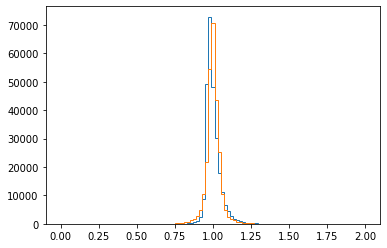

In [6]:
target= np.load('../../polarized_synthesis/data/sim_QiU_stdr_3.npy')
meanQ = np.mean(target.real)
stdQ = np.std(target.real)
meanU = np.mean(target.imag)
stdU = np.std(target.imag)
target = (target.real - meanQ)/(stdQ*20) + 1. + 1j*(target.imag - meanU)/(stdU*20) + 1j

_ = plt.hist(target.real.flatten(), histtype='step', bins=np.linspace(0,2,100))
_ = plt.hist(target.imag.flatten(), histtype='step', bins=np.linspace(0,2,100))

In [7]:
files = [filename for filename in os.listdir('../../polarized_synthesis/long_run/') if '.npy' in filename]
nfiles=len(files)

In [8]:
input_foreground_array = np.empty((nfiles,512,512,2))
    
for i in range(nfiles):
    temp_map = np.load('../../polarized_synthesis/long_run/' + files[i])
    input_foreground_array[i,:,:,0] = ndimage.gaussian_filter(temp_map.real, 1)
    input_foreground_array[i,:,:,1] = ndimage.gaussian_filter(temp_map.imag, 1)

meanQ_final = np.mean(input_foreground_array[:,:,:,0])
stdQ_final = np.std(input_foreground_array[:,:,:,0])
meanU_final = np.mean(input_foreground_array[:,:,:,1])
stdU_final = np.std(input_foreground_array[:,:,:,1])
    
input_foreground_array[:,:,:,0] = (input_foreground_array[:,:,:,0] - meanQ_final)/(20*stdQ_final)
input_foreground_array[:,:,:,1] = (input_foreground_array[:,:,:,1] - meanU_final)/(20*stdU_final)

In [9]:
rotated_foreground_array  = np.vstack([tf.image.rot90(input_foreground_array, k = i) for i in range(4)])

rotated_foreground_array = np.concatenate([rotated_foreground_array,
                                           tf.image.transpose(rotated_foreground_array)]).astype(np.float32)
gc.collect()

451

In [10]:
n_step = 8
grid_step = np.meshgrid(np.linspace(0,map_size*2,n_step+1, dtype=int)[:-1],
                        np.linspace(0,map_size*2,n_step+1, dtype=int)[:-1])
grid_i_index = grid_step[0].flatten()
grid_j_index = grid_step[1].flatten()

noisy_array = np.empty((len(grid_i_index)*rotated_foreground_array.shape[0], map_size,map_size,2), dtype=np.float32)
print(noisy_array.shape)

for i in range(len(grid_i_index)):
    low_lim = i*rotated_foreground_array.shape[0]
    high_lim = (i+1)*rotated_foreground_array.shape[0]
    
    random_amplitude = np.random.normal(1,0.05)
    noisy_array[low_lim:high_lim] = random_amplitude*np.roll(np.roll(rotated_foreground_array, shift=grid_i_index[i],axis=1),
                                            shift=grid_j_index[i],axis=2)[:,:int(map_size),:int(map_size),:]


random_indices = np.arange(noisy_array.shape[0])
np.random.shuffle(random_indices)

noisy_array = noisy_array[random_indices]

(41984, 256, 256, 2)


# Convert to EB

In [11]:
files = sorted(os.listdir('../../polarized_synthesis/data/cmb_signal/maps/'))
full_path_files = [('../../polarized_synthesis/data/cmb_signal/maps/' + file) for file in files if '.npy' in file]
print(len(full_path_files))

n_files = 22000
clean_array = np.stack([np.load(f).transpose(1,2,0) for f in full_path_files[:n_files]])[:,:,:,:]
clean_array = clean_array[:,:,:,2:]
gc.collect()

43200


344

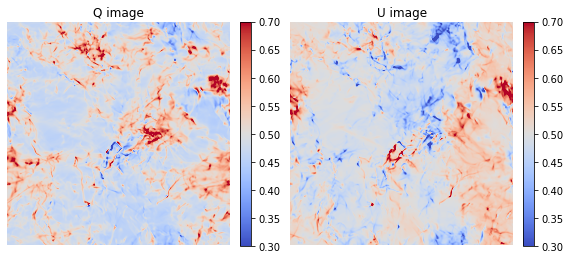

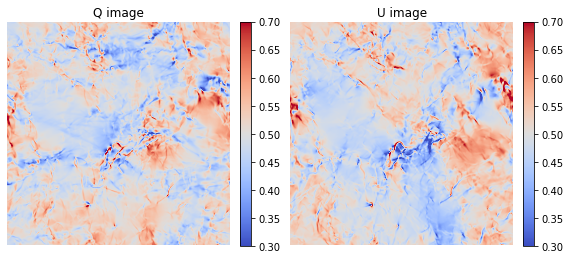

In [12]:
targetE, targetB = ks93(target.real-1., target.imag-1.)
targetE += 0.5
targetB += 0.5

_ = plt.figure(figsize=(8,4))
_ = plt.subplot(1,2,1), plt.imshow(target.real-0.5,
                                   clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Q image'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,2,2), plt.imshow(target.imag-0.5,
                                   clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('U image'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True), plt.show()

_ = plt.figure(figsize=(8,4))
_ = plt.subplot(1,2,1), plt.imshow(targetE,
                                   clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Q image'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,2,2), plt.imshow(targetB,
                                   clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('U image'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.tight_layout(True), plt.show()

In [13]:
for i in range(n_files):
    if i%2000==0: print(i)
    noisy_array[i,:,:,0], noisy_array[i,:,:,1] = ks93(noisy_array[i,:,:,0], noisy_array[i,:,:,1])

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000


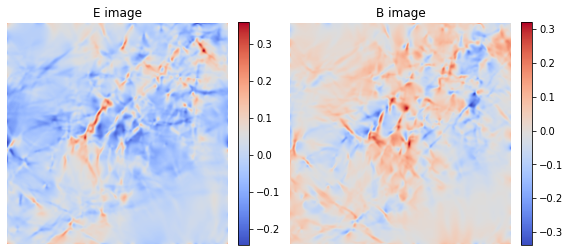

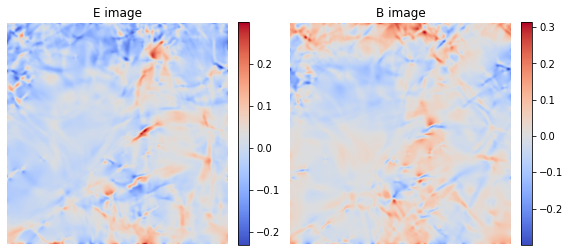

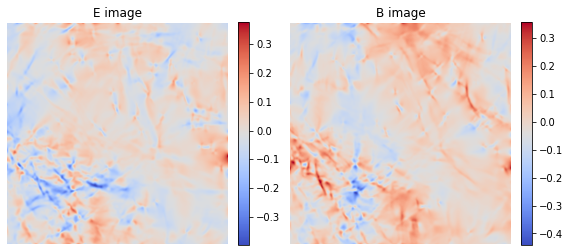

In [14]:
for i in range(3):
    _ = plt.figure(figsize=(8,4))
    _ = plt.subplot(1,2,1), plt.imshow(noisy_array[i,:,:,0],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('E image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.subplot(1,2,2), plt.imshow(noisy_array[i,:,:,1],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('B image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.tight_layout(True), plt.show()

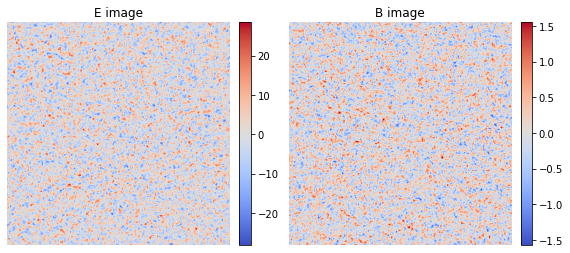

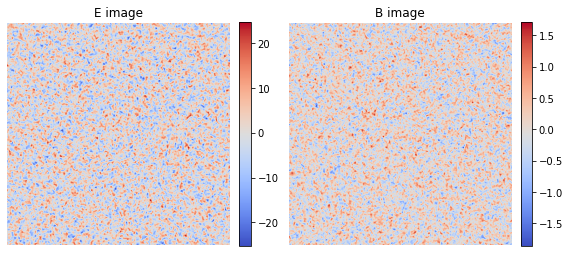

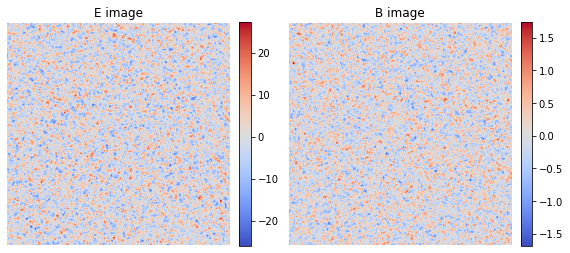

In [15]:
for i in range(3):
    _ = plt.figure(figsize=(8,4))
    _ = plt.subplot(1,2,1), plt.imshow(clean_array[i,:,:,0],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('E image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.subplot(1,2,2), plt.imshow(clean_array[i,:,:,1],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('B image'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.tight_layout(True), plt.show()

In [16]:
for i in range(clean_array.shape[0]):
    if i%(int(clean_array.shape[0]/50))==0: print(i, flush=True)
    clean_array[i,:,:,0] = ndimage.gaussian_filter(clean_array[i,:,:,0], 1)
    clean_array[i,:,:,0] = (clean_array[i,:,:,0] - np.mean(clean_array[i,:,:,0]))
    clean_array[i,:,:,1] = ndimage.gaussian_filter(clean_array[i,:,:,1], 1)
    clean_array[i,:,:,1] = (clean_array[i,:,:,1] - np.mean(clean_array[i,:,:,1]))
gc.collect()

clean_array = (clean_array - np.mean(clean_array))/(30*np.std(clean_array)) + 0.5
noisy_array = noisy_array[:n_files] + clean_array #+ 0.1

test_array_noisy = noisy_array[:n_test]
test_array_clean = clean_array[:n_test]
gc.collect()

noisy_array = noisy_array[n_test:]
clean_array = clean_array[n_test:]
gc.collect()

0
440
880
1320
1760
2200
2640
3080
3520
3960
4400
4840
5280
5720
6160
6600
7040
7480
7920
8360
8800
9240
9680
10120
10560
11000
11440
11880
12320
12760
13200
13640
14080
14520
14960
15400
15840
16280
16720
17160
17600
18040
18480
18920
19360
19800
20240
20680
21120
21560


0

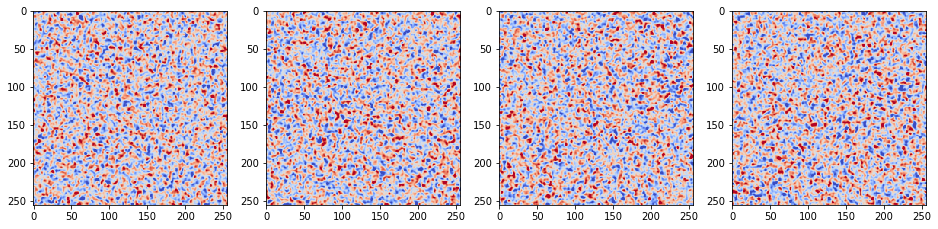

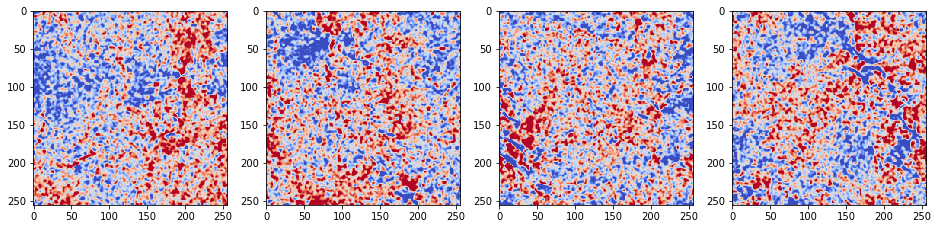

In [17]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1), plt.imshow(clean_array.real[i*20,:,:,0], clim=(0.4, 0.6))
plt.show()

plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1), plt.imshow(noisy_array.real[i*20,:,:,0], clim=(0.4,0.6))
plt.show()

In [18]:
train_gen = cnn.BatchGenerator(noisy_array[:,:,:,0].reshape(list(noisy_array.shape[:3])+[1]),
                               clean_array[:,:,:,0].reshape(list(clean_array.shape[:3])+[1]),
                               gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy[:,:,:,0].reshape(list(test_array_noisy.shape[:3])+[1]),
                              test_array_clean[:,:,:,0].reshape(list(test_array_clean.shape[:3])+[1]),
                              gen_batch_size=batch_size)

cnn_instance = UnetlikeBaseline_new(map_size=map_size, learning_rate=learning_rate, channels=[1,1])
cnn_model = cnn_instance.model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=40,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)), verbose=True)

gc.collect()

Epoch 1/40


/obs/njeffrey/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


626/626 [==============================] - 46s 67ms/step - loss: 0.0116 - val_loss: 9.5841e-04
Epoch 2/40
626/626 [==============================] - 41s 65ms/step - loss: 8.5422e-04 - val_loss: 6.8761e-04
Epoch 3/40
626/626 [==============================] - 41s 66ms/step - loss: 6.5947e-04 - val_loss: 6.0761e-04
Epoch 4/40
626/626 [==============================] - 41s 66ms/step - loss: 5.9154e-04 - val_loss: 5.6515e-04
Epoch 5/40
626/626 [==============================] - 41s 65ms/step - loss: 5.5216e-04 - val_loss: 5.4215e-04
Epoch 6/40
626/626 [==============================] - 41s 65ms/step - loss: 5.2709e-04 - val_loss: 5.2115e-04
Epoch 7/40
581/626 [==========================>...] - ETA: 2s - loss: 5.1090e-04

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [20]:
test_output = cnn_model.predict(test_array_noisy[:5,:,:,0].reshape(5,256,256,1))

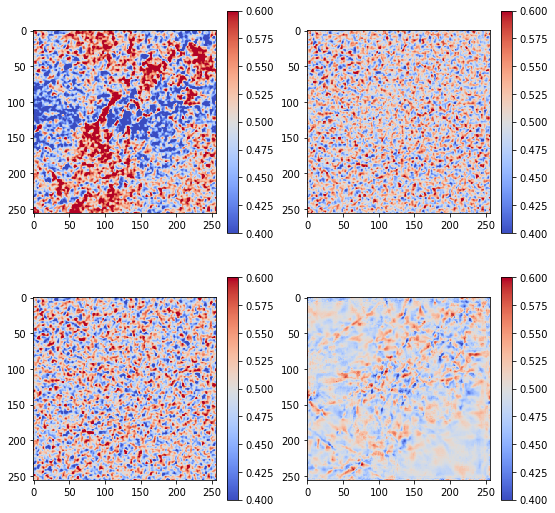

In [21]:
_ = plt.figure(figsize=(9,9))
_ = plt.subplot(221), plt.imshow(test_array_noisy[0,:,:,0], clim=(0.4,0.6)), plt.colorbar()
_ = plt.subplot(222), plt.imshow(test_output[0,:,:,0], clim=(0.4,0.6)), plt.colorbar()
_ = plt.subplot(223), plt.imshow(test_array_clean[0,:,:,0], clim=(0.4,0.6)), plt.colorbar()
_ = plt.subplot(224), plt.imshow((test_array_clean[0,:,:,0]-test_output[0,:,:,0]+0.5), clim=(0.4,0.6))
_ = plt.colorbar()

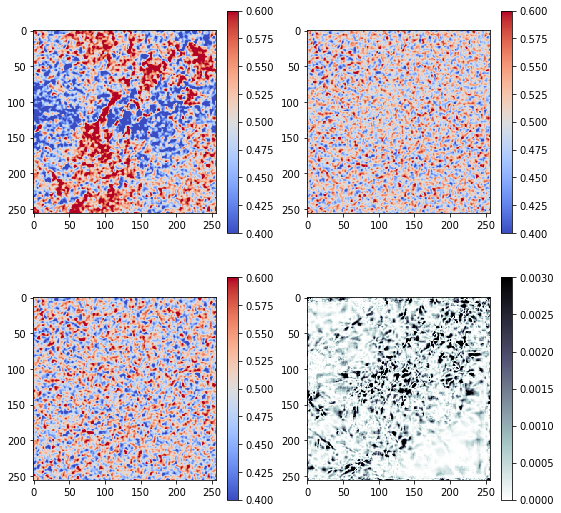

In [22]:
_ = plt.figure(figsize=(9,9))
_ = plt.subplot(221), plt.imshow(test_array_noisy[0,:,:,0], clim=(0.4,0.6)), plt.colorbar()
_ = plt.subplot(222), plt.imshow(test_output[0,:,:,0], clim=(0.4,0.6)), plt.colorbar()
_ = plt.subplot(223), plt.imshow(test_array_clean[0,:,:,0], clim=(0.4,0.6)), plt.colorbar()
_ = plt.subplot(224), plt.imshow((test_array_clean[0,:,:,0]-test_output[0,:,:,0])**2, clim=(0,3e-3), cmap='bone_r')
_ = plt.colorbar()

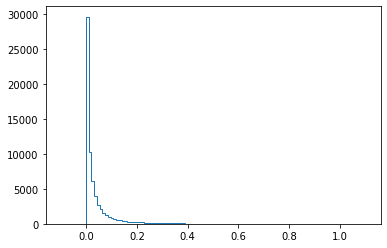

In [23]:
# t = time.time()
# predict_batch = 400
# n_predict_batches = np.ceil(noisy_array.shape[0]/predict_batch).astype(int)
# print(n_predict_batches)
# target_var = np.vstack([cnn_model.predict(noisy_array[i*predict_batch:(i+1)*predict_batch]) 
#                         for i in range(n_predict_batches)])

# print(time.time() - t, flush=True)
# target_var = 100*(target_var - clean_array)**2.

# _ = plt.hist(target_var[0,:,:,0].flatten(),bins=np.linspace(-0.1,1.1,111), histtype='step')

target_var = 100*(cnn_model.predict(np.expand_dims(np.atleast_3d(noisy_array[:,:,:,0]), axis=3)) - \
                  np.expand_dims(np.atleast_3d(clean_array[:,:,:,0]), axis=3))**2.
_ = plt.hist(target_var[0,:,:,0].flatten(),bins=np.linspace(-0.1,1.1,111), histtype='step')

In [24]:
train_gen_var = cnn.BatchGenerator(noisy_array[n_test:, :,:,0].reshape(list(noisy_array[n_test:, :,:,0].shape[:3])+[1]),
                                   target_var[n_test:, :,:,0].reshape(list(noisy_array[n_test:, :,:,0].shape[:3])+[1]),
                                   gen_batch_size=batch_size)
test_gen_var = cnn.BatchGenerator(noisy_array[:n_test, :,:,0].reshape(list(noisy_array[:n_test, :,:,0].shape[:3])+[1]),
                                  target_var[:n_test, :,:,0].reshape(list(noisy_array[:n_test, :,:,0].shape[:3])+[1]),
                                  gen_batch_size=batch_size)

cnn_instance_var = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model_var = cnn_instance_var.model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 256, 256, 16) 64          conv2d_10[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 128, 128, 16) 0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [26]:
history_var = cnn_model_var.fit_generator(generator=train_gen_var,
                         epochs=5,
                         steps_per_epoch=np.ceil(noisy_array[n_test:].shape[0] / int(batch_size)),
                         validation_data=test_gen_var,
                         validation_steps=np.ceil(noisy_array[:n_test].shape[0] / int(batch_size)), verbose=True)

gc.collect()

Epoch 1/5
564/564 [==============================] - 37s 66ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 2/5
564/564 [==============================] - 38s 67ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 3/5
564/564 [==============================] - 37s 66ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 4/5
564/564 [==============================] - 37s 66ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 5/5
564/564 [==============================] - 37s 66ms/step - loss: 0.0105 - val_loss: 0.0110


50

In [27]:
test_var = cnn_model_var.predict(noisy_array[:3, :,:,0].reshape(3,256,256,1))

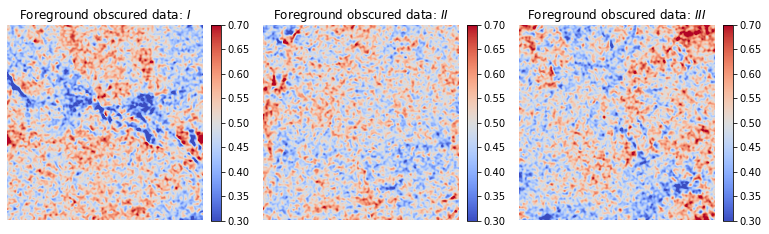

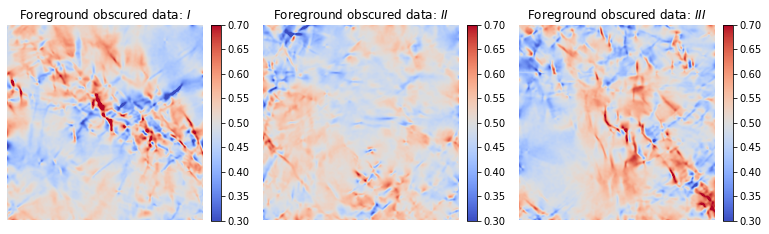

In [28]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow(noisy_array[-n_test,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $I$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(noisy_array[-n_test+1,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $II$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(noisy_array[-n_test+2,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $III$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('foreground_data_examples_E.png', dpi=300)

_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow(noisy_array[-n_test,:,:,1], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $I$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(noisy_array[-n_test+1,:,:,1], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $II$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(noisy_array[-n_test+2,:,:,1], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title(r'Foreground obscured data: $III$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('foreground_data_examples_E.png', dpi=300)

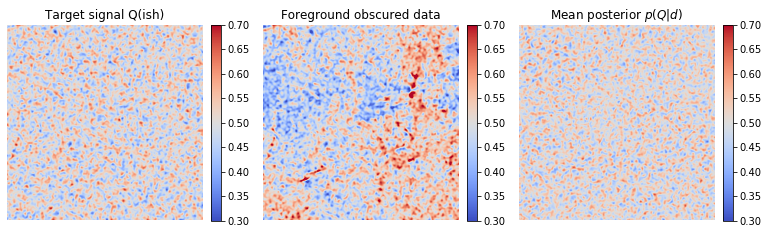

In [29]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow(clean_array[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Target signal Q(ish)'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(noisy_array[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(Q | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_pol_E.png', dpi=300)

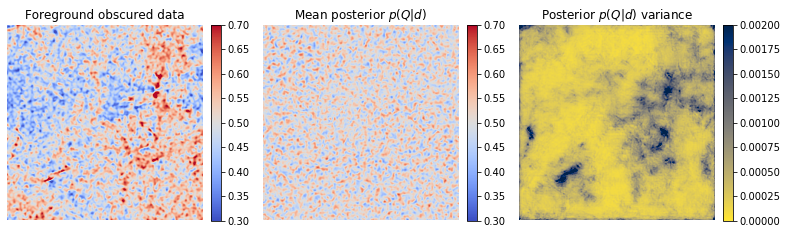

In [30]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1),  plt.imshow(noisy_array[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(test_output[0,:,:,0], clim=(0.3,0.7),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(Q | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow(test_var[0,:,:,0]/100., clim = (0.,2e-3),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(Q | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_var_pol_E.png', dpi=300)

In [31]:
from astropy.io import fits

In [32]:
Q_alt = np.array(fits.open('../../polarized_synthesis/data/alternative/Q_y0_z_output_00071.fits')[0].data).astype(np.float32)
U_alt = np.array(fits.open('../../polarized_synthesis/data/alternative/U_y0_z_output_00071.fits')[0].data).astype(np.float32)

In [61]:
input_patch = np.stack([Q_alt, U_alt], axis=2)
# input_patch = np.stack([input_patch[:256,:256],
#                               input_patch[256:,:256],
#                               input_patch[256:,256:],
#                               input_patch[:256,256:]])
input_patch = np.stack([input_patch[:256,:256]])

input_patch[0,:,:,0], input_patch[0,:,:,1] = ks93(input_patch[0,:,:,0], input_patch[0,:,:,1])

input_patch[:,:,:,0] = (input_patch[:,:,:,0] - np.mean(input_patch[:,:,:,0]))/(np.std(input_patch[:,:,:,0])*20.)
input_patch[:,:,:,1] = (input_patch[:,:,:,1] - np.mean(input_patch[:,:,:,1]))/(np.std(input_patch[:,:,:,1])*20.)
input_patch += 0.5

input_signal_example = np.reshape(test_array_clean[0], (1,256,256,2))
input_patch_example = input_patch + input_signal_example - 0.5

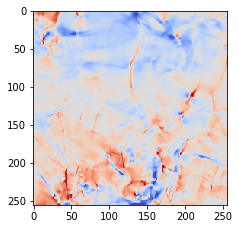

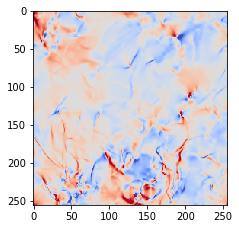

In [62]:
plt.figure(figsize=(16,4))
for i in range(1):
    plt.subplot(1,4,i+1), plt.imshow(input_patch[i,:,:,0], clim=(0.3,0.7))
plt.show()

plt.figure(figsize=(16,4))
for i in range(1):
    plt.subplot(1,4,i+1), plt.imshow(input_patch[i,:,:,1], clim=(0.3,0.7))
plt.show()

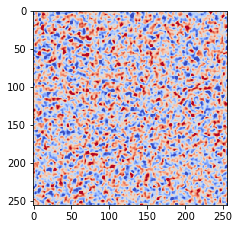

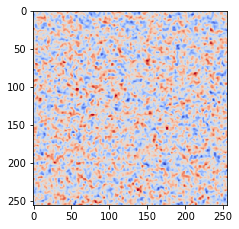

In [63]:
plt.figure(figsize=(16,4))
for i in range(1):
    plt.subplot(1,4,i+1), plt.imshow(input_signal_example[i,:,:,0], clim=(0.4,0.6))
plt.show()

plt.figure(figsize=(16,4))
for i in range(1):
    plt.subplot(1,4,i+1), plt.imshow(input_signal_example[i,:,:,1], clim=(0.49,0.51))
plt.show()

In [64]:
valid_output = cnn_model.predict(input_patch_example[0,:,:,0].reshape(1,256,256,1))
valid_var = cnn_model_var.predict(input_patch_example[0,:,:,0].reshape(1,256,256,1))

In [65]:
input_patch_example[:,:,:,0].shape

(1, 256, 256)

In [67]:
residuals  = (valid_output[0,5:-5,5:-5,0] - input_signal_example[0,5:-5,5:-5,0]).flatten()
sigma = np.sqrt(valid_var[0,5:-5,5:-5,0]/100.).flatten()

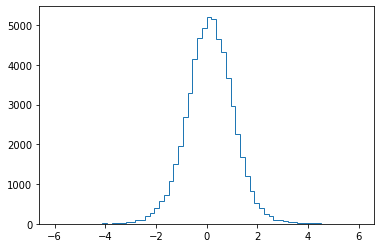

In [68]:
_ = plt.hist(residuals/sigma, bins=np.linspace(-6,6,65), histtype='step')

In [69]:
gaussian_samples = np.random.normal(0,1,int(1e7))

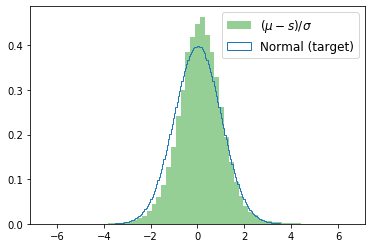

In [70]:
_ = plt.hist(residuals/sigma, bins=np.linspace(-6.5,6.5,64), color='C2', density=True, alpha=0.5,label=r'$(\mu - s)/\sigma$')
_ = plt.hist(gaussian_samples, bins=np.linspace(-6.5,6.5,256), histtype='step', density=True, label='Normal (target)')
_ = plt.legend(fontsize=12.), plt.savefig('validation_residuals_Q_1_1.png',dpi=100)